In [320]:
from datetime import datetime, timedelta
from collections import defaultdict
from time import time
import os
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tweepy

In [2]:
#inputs
bearer_token = "AAAAAAAAAAAAAAAAAAAAAH4BlAEAAAAA3Dd4SGtdK%2FWbAqlEdIcXzoPB4%2BA%3DwDjEbymhTQgnmvHM8Vvetae79bgdBz1eyHWSyXZVqRnCCir1nA" #mpolo
limit = 2 #number of requests of `max_results` tweets each

In [3]:
#create paginator
client = tweepy.Client(bearer_token)
paginator = tweepy.Paginator( #TODO vedi come filtrare via tutti i tweet con media file
    method=client.search_recent_tweets,
    limit=limit,
    query=(
        '(context:131.825047692124442624 OR context:152.825047692124442624) ' #https://github.com/twitterdev/twitter-context-annotations
        '-is:retweet ' #TODO check and search doc for other usefull operators
        'lang:en'),
    end_time=datetime.utcnow()-timedelta(days=6), #go backwards starting from 6 days ago
    expansions=['author_id'], #TODO search doc for other usefull expansions
    max_results=100, #500 if academic research access
    tweet_fields=['public_metrics'], #TODO search doc for other usefull tweet fields
    user_fields=['public_metrics']) #TODO search doc for usefull user fields

#download tweets
data = defaultdict(list)
for response in paginator:
    for tweet, user in zip(response.data, response.includes['users']):
        if tweet.author_id == user.id: #some don't match for no reason
            data['text'] += [tweet.text]
            data['likes'] += [tweet.public_metrics['like_count']]
            data['followers'] += [user.public_metrics['followers_count']]

#save tweets
os.makedirs('debug_sets', exist_ok=True)
set_id = int(time() % 1e6) #unique for 11 days
pd.DataFrame(data).to_csv(f'debug_sets/{set_id}.csv', index=False)
set_id

409165

TODO `search_recent_tweets` is up to 7 days. To search further back, use [search_all_tweets](https://docs.tweepy.org/en/stable/client.html#tweepy.Client.search_all_tweets) instead (and add `start_time` parameter). But it needs the [academic research access](https://developer.twitter.com/en/docs/projects). It also increases the monthly cap from 500,000 to 10 million.

In [393]:
#load tweets
set_id = 407729
df = pd.read_csv(f'debug_sets/{set_id}.csv')
df = df[df['followers'] > 0] #drop those without followers
df.head(2)

,text,likes,followers
0,I guess I had too much soju and ume on a weekd...,0.0,39.0
1,"Egyptian rice, tuna, ground beef, onions, and ...",2.0,90.0


array([0.21254942])

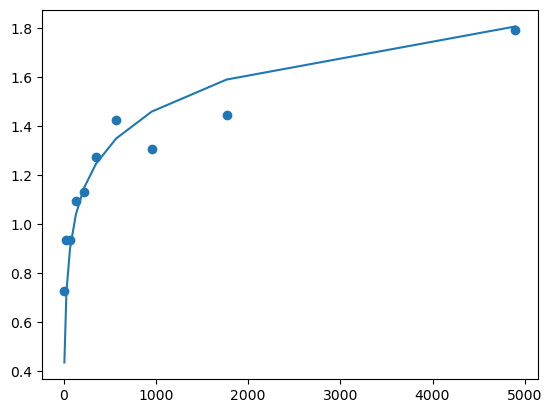

In [394]:
#remove outliers TODO tune q (eg.: 0.95)
q = df.quantile(0.95, numeric_only=True) #numeric_only to fix warning
df_q = df[(df['likes'] < q['likes']) & (df['followers'] < q['followers'])].copy() #copy to fix warning

#group by followers TODO tune number of groups (eg.: 10)
df_q.sort_values(by='followers', inplace=True, ignore_index=True)
df_q['group'] = df_q.index//(len(df_q)/10) #groups of same size
df_q = df_q.groupby('group').mean(numeric_only=True) #numeric_only to fix warning

#plot average followers vs average likes
x = df_q['followers']
y = df_q['likes']
plt.scatter(x, y)

#fit log curve and plot it
def curve(x, coeff):
    return coeff * np.log(1+x)
coeff, _ = curve_fit(f, xdata=x, ydata=y)
plt.plot(x, curve(x, coeff))
coeff

TODO togli tweet con immagini ecc.

TODO studia query [qua](https://developer.twitter.com/en/docs/twitter-api/tweets/search/integrate/build-a-query)
    * continua a studiare link al tutorial "Building high-quality..." (da "Example queries & rules")
        * finora interessante solo:
            * link ad [annotations](https://developer.twitter.com/en/docs/twitter-api/annotations/overview)
            * In the new Twitter API (recent search and filtered stream), AND is applied before OR

verifica quello che dice chatGPT (i like invece credo li abbia solo il tweet originale):
"When you search for tweets using Tweepy, you will get the original tweet and any retweeted versions of that tweet as separate results. Retweets are considered to be separate tweets from the original, so you will receive multiple results for the same content if it has been retweeted multiple times. To avoid receiving duplicate results, you can use the .dedup() method of the Cursor object to remove duplicates. This will only return one result for each unique tweet, even if it has been retweeted multiple times."

inoltre like sempre a [zero se è retweet](https://twittercommunity.com/t/tweets-having-likes-more-than-zero-always-shows-zero-while-on-twitter-it-shows-more-than-zero-likes-it-only-shows-retweets-counts-accurate-please-tell-me-how-to-get-the-correct-like-count-as-well-i-am-using-twitter-v2-search-api/160840/4)

In [432]:
#normalize likes
epsilon = 1e-5
df['popularity'] = (df['likes']+epsilon)/np.log1p(df['followers']) #problema se likes 0 perché tutti 0
                        #servirebbe modo che anche tweet senza like siano più popolari di tweet con pochi
                        #like e tantissimi follower se ci si aspetterebbero molti più like

#group by popularity
df.sort_values(by='popularity', inplace=True, ignore_index=True)
df['pop_level'] = df.index//(len(df)/3) #groups of same size
df.iloc[3100:3110]

,text,likes,followers,popularity,pop_level
3100,@ukrainiansquad @joncoopertweets To every sing...,0.0,99.0,0.000002,0.0
3101,Click L*i*nk for More INFO&gt;&gt;&gt;&gt;http...,0.0,99.0,0.000002,1.0
3102,So many things! You can drive an hour west and...,0.0,99.0,0.000002,1.0
3103,@TerrillCharming Did you get a BGE? If you eat...,0.0,99.0,0.000002,1.0
3104,@ChampMcCall @DisgruntledPat1 @Jessrocks71 @ja...,0.0,99.0,0.000002,1.0
3105,"30 day challenge day 4 complete 25 sit-ups, cr...",0.0,99.0,0.000002,1.0
3106,@KFooglefam @davidmweissman @mattgaetz Yes and...,0.0,99.0,0.000002,1.0
3107,Bale Breaker Flaming Alternator (@balebreaker...,0.0,99.0,0.000002,1.0
3108,Eating healthy kills people according to moron...,0.0,99.0,0.000002,1.0
3109,Drinking a Holiday Ale by @newbelgium @ Untapp...,0.0,98.0,0.000002,1.0


In [409]:
df.quantile(0.30, numeric_only=True)

likes           0.0
followers     108.0
popularity      0.0
pop_level       0.0
Name: 0.3, dtype: float64

In [420]:
1e-5 == 0.0000001

False

In [423]:
np.log1p(1000e6)

20.72326583794641